In [28]:
import random
import numpy as np
import cv2
import pandas as pd
from matplotlib import pyplot as plt
import os 
import json


def generate_triangles(N, im_width, im_height, max_area_percentage):
    max_area = (im_width * im_height) * max_area_percentage / 100.0
    triangle_images = []
    bounding_boxes = []

    for _ in range(N):
        area = max_area
        while area >= max_area:
            # Generate random vertices for the triangle
            vertices = [(random.randint(0, im_width), random.randint(0, im_height)) for _ in range(3)]
            
            # Calculate the area of the triangle using shoelace formula
            area = 0.5 * abs(
                vertices[0][0] * (vertices[1][1] - vertices[2][1]) +
                vertices[1][0] * (vertices[2][1] - vertices[0][1]) +
                vertices[2][0] * (vertices[0][1] - vertices[1][1])
            )

        if area <= max_area:
            # Create a blank image
            img = np.zeros((im_height, im_width, 3), dtype=np.uint8)

            # Fill the triangle with a random color
            color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            cv2.drawContours(img, [np.array(vertices)], 0, color, -1)

            # Compute bounding box coordinates
            x_values = [vertex[0] for vertex in vertices]
            y_values = [vertex[1] for vertex in vertices]
            bounding_box = (min(x_values), min(y_values), max(x_values), max(y_values))
            bounding_boxes.append(bounding_box)

            triangle_images.append(img)

    return triangle_images, bounding_boxes


def generate_squares(N, im_width, im_height, max_area_percentage):
    max_area = (im_width * im_height) * max_area_percentage / 100.0
    square_images = []
    bounding_boxes = []

    for _ in range(N):
        area = max_area
        while area >= max_area:
            # Generate random dimensions and position for the square
            side_length = random.randint(10, min(im_width, im_height) // 2)
            x_position = random.randint(0, im_width - side_length)
            y_position = random.randint(0, im_height - side_length)
            
            # Calculate the area of the square
            area = side_length ** 2

        if area <= max_area:
            # Create a blank image
            img = np.zeros((im_height, im_width, 3), dtype=np.uint8)

            # Fill the square with a random color
            color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            cv2.rectangle(img, (x_position, y_position), (x_position + side_length, y_position + side_length), color, -1)

            # Compute bounding box coordinates
            bounding_box = (x_position, y_position, x_position + side_length, y_position + side_length)
            bounding_boxes.append(bounding_box)

            square_images.append(img)

    return square_images, bounding_boxes


def generate_circles(N, im_width, im_height, max_area_percentage):
    max_area = (im_width * im_height) * max_area_percentage / 100.0
    circle_images = []
    bounding_boxes = []

    for _ in range(N):
        area = max_area
        while area >= max_area:
            # Generate random circle parameters
            radius = random.randint(10, min(im_width, im_height) // 2)
            center_x = random.randint(radius, im_width - radius)
            center_y = random.randint(radius, im_height - radius)
            
            area = np.pi * radius ** 2

        if area <= max_area:
            # Create a blank image
            img = np.zeros((im_height, im_width, 3), dtype=np.uint8)

            # Fill the circle with a random color
            color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            cv2.circle(img, (center_x, center_y), radius, color, -1)

            # Compute bounding box coordinates
            bounding_box = (center_x - radius, center_y - radius, center_x + radius, center_y + radius)
            bounding_boxes.append(bounding_box)

            circle_images.append(img)

    return circle_images, bounding_boxes


def create_bounding_box_dataframe(cls, image_name, ffp, bounding_boxes):
    data = []
    for i, bounding_box in enumerate(bounding_boxes):
        xmin, ymin, xmax, ymax = bounding_box
        data.append({
            'class' : cls,
            'image_name': image_name,
            'ffp': ffp,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })
    return pd.DataFrame(data)


def stack_images(images):
    # Get the dimensions of the first image
    im_height, im_width, _ = images[0].shape

    # Create a blank canvas to stack images onto
    stacked_image = np.zeros((im_height, im_width, 3), dtype=np.uint8)

    # Stack each image onto the blank canvas
    for image in images:
        # Add the image to the blank canvas
        stacked_image = cv2.add(stacked_image, image)

    return stacked_image


def calculate_yolo_bboxes(df):
    """
    Calculate bounding boxes in YOLO format from DataFrame columns.

    Parameters:
        df (pandas.DataFrame): DataFrame containing columns: xmin, ymin, xmax, ymax, image_width, image_height.

    Returns:
        pandas.DataFrame: DataFrame with additional columns for YOLO format bounding boxes.
    """

    df['x_center'] = (df['xmin'] + df['xmax']) / (2 * df['image_width'])
    df['y_center'] = (df['ymin'] + df['ymax']) / (2 * df['image_height'])
    df['width'] = (df['xmax'] - df['xmin']) / df['image_width']
    df['height'] = (df['ymax'] - df['ymin']) / df['image_height']

    return df


# def format_yolo_string(df):
#     """
#     Format YOLO string from DataFrame columns.

#     Parameters:
#         df (pandas.DataFrame): DataFrame containing columns: x_center, y_center, width, height.

#     Returns:
#         pandas.Series: Series containing formatted YOLO strings.
#     """
#     yolo_strings = df[['x_center', 'y_center', 'width', 'height']].astype(float).astype(str).apply(lambda x: ' '.join(x), axis=1)
#     return yolo_strings

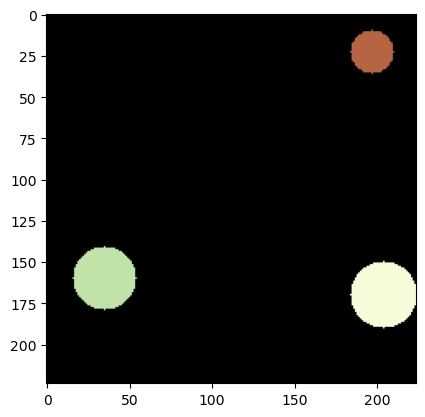

In [2]:
N = 3
im_width = 224
im_height = 224
max_area_percentage = 5

images, bounding_boxes = generate_triangles(N, im_width, im_height, max_area_percentage)
images, bounding_boxes = generate_circles(N, im_width, im_height, max_area_percentage)
#images, bounding_boxes = generate_squares(N, im_width, im_height, max_area_percentage)
stacked_image = stack_images(images)

plt.imshow(stacked_image)

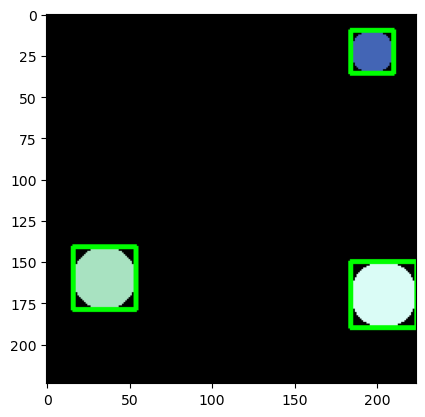

In [3]:
# Draw bounding boxes on the image
for bbox in bounding_boxes:
    x_min, y_min, x_max, y_max = bbox
    cv2.rectangle(stacked_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

# Show the image with bounding boxes
plt.imshow(cv2.cvtColor(stacked_image, cv2.COLOR_BGR2RGB))

In [28]:
create_bounding_box_dataframe('klasa', 'test.jpg', '/test.jpg', bounding_boxes)

,class,image_name,ffp,xmin,ymin,xmax,ymax
0,klasa,test.jpg,/test.jpg,72,29,184,97
1,klasa,test.jpg,/test.jpg,28,126,205,157
2,klasa,test.jpg,/test.jpg,96,16,149,139


In [14]:
!pwd

/home/alice/github/korki


In [68]:
# Example usage:
N = 3
im_width = 600
im_height = 600
max_area_percentage = 5
samples = 300

# ściezka pod którą wygenerujemy dataset
root_dir = '/home/joyvian/github/korki/detektor/dataset'

# słownik z funkcjami
classes = {'circle':generate_circles,
           'square':generate_squares,
           'triangle':generate_triangles}

# df wynikowy zawierający wszystkie labele
df = pd.DataFrame()

os.makedirs(os.path.join(root_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(root_dir, 'labels'), exist_ok=True)

cc = 0 # numerowanie zdjęć

out_dir = os.path.join(root_dir, 'images') # tu uważaj
for cls, fun in classes.items():
    for i in range(samples):
        cc += 1
        images, bounding_boxes = fun(N, im_width, im_height, max_area_percentage)
        stacked_image = stack_images(images)
        image_name = str(cc)+'_'+str(i)+'.png'
        
        ffp = os.path.join(out_dir, image_name)
        cv2.imwrite(ffp, stacked_image) #

        tmp = create_bounding_box_dataframe(cls, image_name, ffp, bounding_boxes)
        tmp['image_width'] = im_width
        tmp['image_height'] = im_height
        tmp['image_name'] = image_name
        df = pd.concat([df, tmp], axis=0)

# kodowanie labeli za pomocą int
label_encoder = LabelEncoder()
df['class_encoded'] = label_encoder.fit_transform(df['class'])
df = calculate_yolo_bboxes(df)

out_dir = os.path.join(root_dir, 'labels') # tu uważaj
for image_name in df.image_name.unique():
    sub = df[df.image_name == image_name]
    ffp = os.path.join(out_dir, os.path.splitext(image_name)[0]+'.txt')

    with open(ffp, 'w') as file:
        for idx, row in sub.iterrows():
            file.write(str(row['class_encoded'])+' '+str(row['x_center'])+' '+str(row['y_center'])+' '+str(row['width'])+' '+str(row['height'])+'\n')

In [70]:
# jeszcze plik yaml
ffp = os.path.join(root_dir, 'config.yaml')

yaml_dir = os.path.join(root_dir,'train') # tu uważaj
with open(ffp, 'w') as f:
    f.write('path: '+yaml_dir+ '\n')
    f.write('train: images \n')
    f.write('val: images \n')
    f.write('\n')
    f.write('# Classes'+ '\n')
    f.write('names:\n')
    for idx, row in df[['class','class_encoded']].drop_duplicates().iterrows():
        f.write('  '+str(row['class_encoded'])+': '+str(row['class'])+'\n')